In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/lankenau/isotools/src')

In [3]:
import os
import logging
from isotools import Transcriptome
from isotools import __version__ as isotools_version
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# set up logging
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)
logger = logging.getLogger("isotools")
logger.info(f"This is isotools version {isotools_version}")

INFO:This is isotools version 0.3.5rc11


In [ ]:
basepath = '/path/to/code/snakemake-pipeline/'
version = 2
TISSUES = ["aorta", "brain", "colon", "heart", "lung", "muscle"]
path = os.path.join(basepath, "results/isotools_v{version}/pkl/{tissue}.pkl")

In [ ]:
isoseqs = [Transcriptome.load(path.format(version=version, tissue=tissue)) for tissue in TISSUES]

In [6]:
results = []
for i, isoseq in enumerate(isoseqs):
    group = {TISSUES[i]: [sample for samples in isoseq.groups().values() for sample in samples]}
    results.append(isoseq.filter_stats(
        tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
        groups=group,
        weight_by_coverage=True,
        min_coverage=2))

In [7]:
results

[(                      aorta
  total             2779189.0
  PASS              2283734.0
  INTERNAL_PRIMING   320615.0
  FRAGMENT           159604.0
  RTTS                15881.0,
  {'ylabel': 'fraction of reads', 'title': 'Expressed Transcripts > 2 reads'}),
 (                      brain
  total             4665755.0
  PASS              3639195.0
  INTERNAL_PRIMING   879175.0
  FRAGMENT           126085.0
  RTTS                22110.0,
  {'ylabel': 'fraction of reads', 'title': 'Expressed Transcripts > 2 reads'}),
 (                      colon
  total             2292196.0
  PASS              2118851.0
  FRAGMENT           131813.0
  INTERNAL_PRIMING    28968.0
  RTTS                13298.0,
  {'ylabel': 'fraction of reads', 'title': 'Expressed Transcripts > 2 reads'}),
 (                       heart
  total             21076160.0
  PASS              18394823.0
  FRAGMENT           1710853.0
  INTERNAL_PRIMING    832650.0
  RTTS                146888.0,
  {'ylabel': 'fraction of read

<Axes: title={'center': 'Expressed Transcripts > 2 reads'}, ylabel='fraction of reads'>

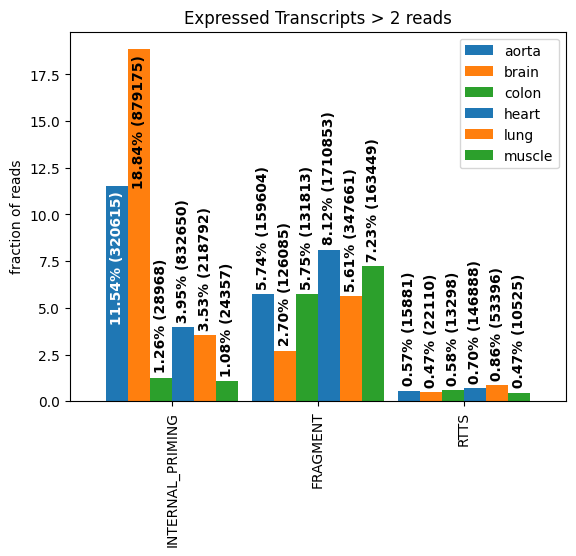

In [9]:
from isotools.plots import plot_bar, plot_distr
fig, axs = plt.subplots(1,1)

plot_bar(pd.concat([r[0] for r in results], axis=1), ax=axs, drop_categories=['PASS'], bar_width=.9,
         legend=True, **results[0][1])

In [10]:
heart = isoseqs[3]
group = {'heart': [sample for samples in heart.groups().values() for sample in samples]}

In [11]:
heart.groups()

{'heart': ['ENCSR984OAE',
  'ENCSR994YZY',
  'ENCSR728TXV',
  'ENCSR549ELD',
  'ENCSR782LGT',
  'ENCSR514YQN',
  'ENCSR700XDQ',
  'ENCSR424QFN',
  'ENCSR575LWI',
  'ENCSR329ZQG',
  'ENCSR553SVP',
  'ENCSR777CCI',
  'ENCSR435UUS',
  'ENCSR899GAP',
  'ENCSR591OZR',
  'ENCSR786FLO']}

In [12]:
def compute_tr_stats(isoseq, groups):
    tr_stats = [
        isoseq.transcript_length_hist(groups=groups, add_reference=True, min_coverage=2, tr_filter=dict(query='not NOVEL_GENE'), ref_filter=dict(query='')), #HIGH_SUPPORT
        isoseq.downstream_a_hist(groups=groups, min_coverage=2, transcript_filter=dict(query='not(NOVEL_GENE and UNSPLICED)'), ref_filter=dict(query='not UNSPLICED')), # known or multiexon
        isoseq.downstream_a_hist(groups=groups, min_coverage=2, transcript_filter=dict(query='(NOVEL_GENE and UNSPLICED)')), # novel unspliced
        isoseq.direct_repeat_hist(groups=groups, min_coverage=2, bins=np.linspace(-.5,20.5,22))
        ]

    for _,par in tr_stats:
        del par['title']

    # combine downstream A distributions in novel unspliced trs and in the rest trs into one plot tr_stats[4]
    tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'), tr_stats[1][0].add_suffix(' known multiexon')],axis=1), tr_stats[2][1]))

    return tr_stats

<Axes: xlabel='fraction of A downstream the transcript', ylabel='density'>

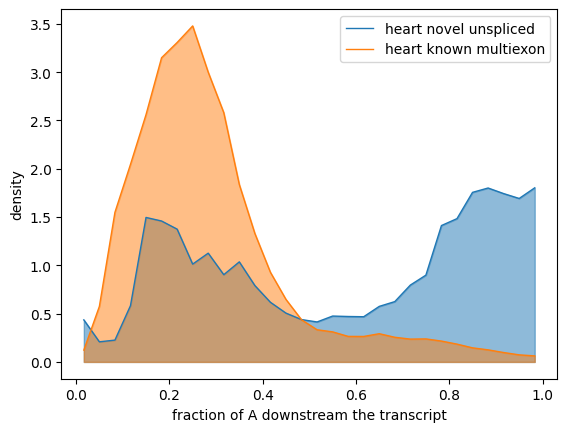

In [13]:
tr_stats = compute_tr_stats(heart, group)

fig, axs = plt.subplots(1,1)
plot_distr(tr_stats[4][0], smooth=3, ax=axs, density=True, fill=True, **tr_stats[4][1])

In [14]:
classification = os.path.join(basepath, 'results/sqanti/isotools_v{version}/qc/{tissue}/{tissue}_classification.txt')
for tissue, isoseq in zip(TISSUES, isoseqs):
    isoseq.import_sqanti_classification(classification.format(version=version, tissue=tissue))

100%|██████████| 30022/30022 [00:10<00:00, 2943.05it/s]


In [15]:
for isoseq in isoseqs:
    isoseq.add_filter(tag='SQANTI_SUPPORT', expression='CAGE_SUPPORT and TSS_RATIO and POLYA_SITE and POLYA_MOTIF', context='transcript', update=True)

In [16]:
for i, isoseq in enumerate(isoseqs):
    count = 0
    for transcript in isoseq.iter_transcripts(query='SQANTI_SUPPORT'):
        count += 1
    print(TISSUES[i], count)

aorta 7468
brain 11875
colon 8955
heart 23636
lung 14406
muscle 7635


In [17]:
for i, isoseq in enumerate(isoseqs):
    count = 0
    for transcript in isoseq.iter_transcripts(query='FRAGMENT'):
        count += 1
    print(TISSUES[i], count)

aorta 40239
brain 35903
colon 37759
heart 143156
lung 71522
muscle 32168


In [18]:
for i, isoseq in enumerate(isoseqs):
    count = 0
    for transcript in isoseq.iter_transcripts():
        count += 1
    print(TISSUES[i], count)

aorta 519747
brain 656982
colon 379246
heart 1391697
lung 818197
muscle 273424


In [19]:
coordination_results = isoseqs[4]['ENSG00000168484.13'].coordination_test(
    event_type=["TSS", "PAS"],
    min_total=10,
    min_alt_fraction=.01,
    transcript_filter="SQANTI_SUPPORT",
)
col_names = ("gene_id", "gene_name", "strand", "eventA_type", "eventB_type", "eventA_start", "eventA_end",
                 "eventB_start", "eventB_end", "pvalue", "statistic", "log2OR", "dcPSI_AB", "dcPSI_BA", "priA_priB", "priA_altB", "altA_priB",
                 "altA_altB", "priA_priB_transcript_ids", "priA_altB_transcript_ids", "altA_priB_transcript_ids", "altA_altB_transcript_ids")

res = pd.DataFrame(coordination_results, columns=col_names)
res

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,dcPSI_AB,dcPSI_BA,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids


In [20]:
res.columns

Index(['gene_id', 'gene_name', 'strand', 'eventA_type', 'eventB_type',
       'eventA_start', 'eventA_end', 'eventB_start', 'eventB_end', 'pvalue',
       'statistic', 'log2OR', 'dcPSI_AB', 'dcPSI_BA', 'priA_priB', 'priA_altB',
       'altA_priB', 'altA_altB', 'priA_priB_transcript_ids',
       'priA_altB_transcript_ids', 'altA_priB_transcript_ids',
       'altA_altB_transcript_ids'],
      dtype='object')

In [21]:
coordination_results = [isoseq.coordination_test(
    event_type=["TSS", "PAS"],
    min_total=10,
    min_alt_fraction=.01,
    # min_dist_AB=25,
    transcript_filter="SQANTI_SUPPORT",
) for isoseq in isoseqs]
coordination_results_sig = [c[c["padj"] < 0.05] for c in coordination_results]
coordination_results_sig[3]

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,dcPSI_AB,dcPSI_BA,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids
1,ENSG00000118217.7,ATF6,+,TSS,PAS,161766319,161766341,161888549,161959059,4.343483e-06,...,-0.230769,-0.769231,0,20,6,0,[],[3],[4],[]
2,ENSG00000118217.7,ATF6,+,TSS,PAS,161766319,161766341,161959022,161959059,2.315669e-06,...,-0.016529,-0.878788,38,319,6,0,[2],"[0, 1]",[4],[]
3,ENSG00000058668.16,ATP2B4,+,TSS,PAS,203626799,203626829,203733623,203744077,3.299392e-02,...,0.011725,0.461187,202,230,0,6,[1],[0],[],[2]
4,ENSG00000188807.13,TMEM201,+,TSS,PAS,9588776,9588908,9604947,9614874,2.251946e-12,...,0.977273,0.977273,258,0,0,6,[0],[],[],[1]
6,ENSG00000259030.8,FPGT-TNNI3K,+,TSS,PAS,74198243,74235388,74240680,74242358,9.500119e-10,...,0.938776,0.938776,92,0,0,6,[4],[],[],[3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,ENSG00000107104.21,KANK1,+,TSS,PAS,504729,547116,549529,746101,1.649383e-07,...,-0.845528,-0.032520,30,8,208,0,"[16, 3]","[6, 7]","[1, 17, 5, 2, 4, 0, 20, 15]",[]
203,ENSG00000138835.24,RGS3,+,TSS,PAS,113463726,113565056,113592998,113597729,2.314185e-14,...,0.048925,0.049162,11,3,2,205,[8],[4],"[1, 9]","[2, 3]"
204,ENSG00000137094.16,DNAJB5,+,TSS,PAS,34989744,34992855,34997393,34998421,1.455415e-137,...,-0.675248,-0.324752,0,164,341,0,[],"[1, 2]","[0, 3]",[]
207,ENSG00000094631.22,HDAC6,+,TSS,PAS,48802066,48802209,48806812,48824969,2.415140e-06,...,-0.630952,-0.035053,0,4,106,2,[],[9],"[1, 5, 10, 0]","[4, 7]"


In [22]:
for i, res in enumerate(coordination_results_sig):
    res.to_csv(f'results/coordination_results_sig_{TISSUES[i]}.tsv', sep='\t')

coordination_results_unfiltered = [isoseq.coordination_test(
    event_type=["TSS", "PAS"],
) for isoseq in isoseqs]
coordination_results_unfiltered_sig = [c[c["padj"] < 0.05] for c in coordination_results_unfiltered]
coordination_results_unfiltered_sig[1]

([<matplotlib.axis.YTick at 0x7fa38a3a0a10>,
 [Text(0, 0.5, 'pri'), Text(0, 1.5, 'alt')])

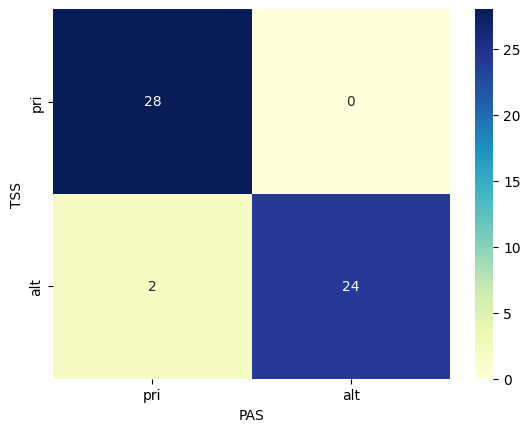

In [23]:
# Display a contingency table for a specific event
first_event = coordination_results_sig[1].iloc[1]
con_tab = [[first_event["priA_priB"], first_event["priA_altB"]], [first_event["altA_priB"], first_event["altA_altB"]]]
sns.heatmap(con_tab, annot=True, fmt="d", cmap="YlGnBu")
# Axis labels
plt.ylabel("TSS")
plt.xlabel("PAS")
# ticks
plt.xticks([0.5, 1.5], ["pri", "alt"])
plt.yticks([0.5, 1.5], ["pri", "alt"])

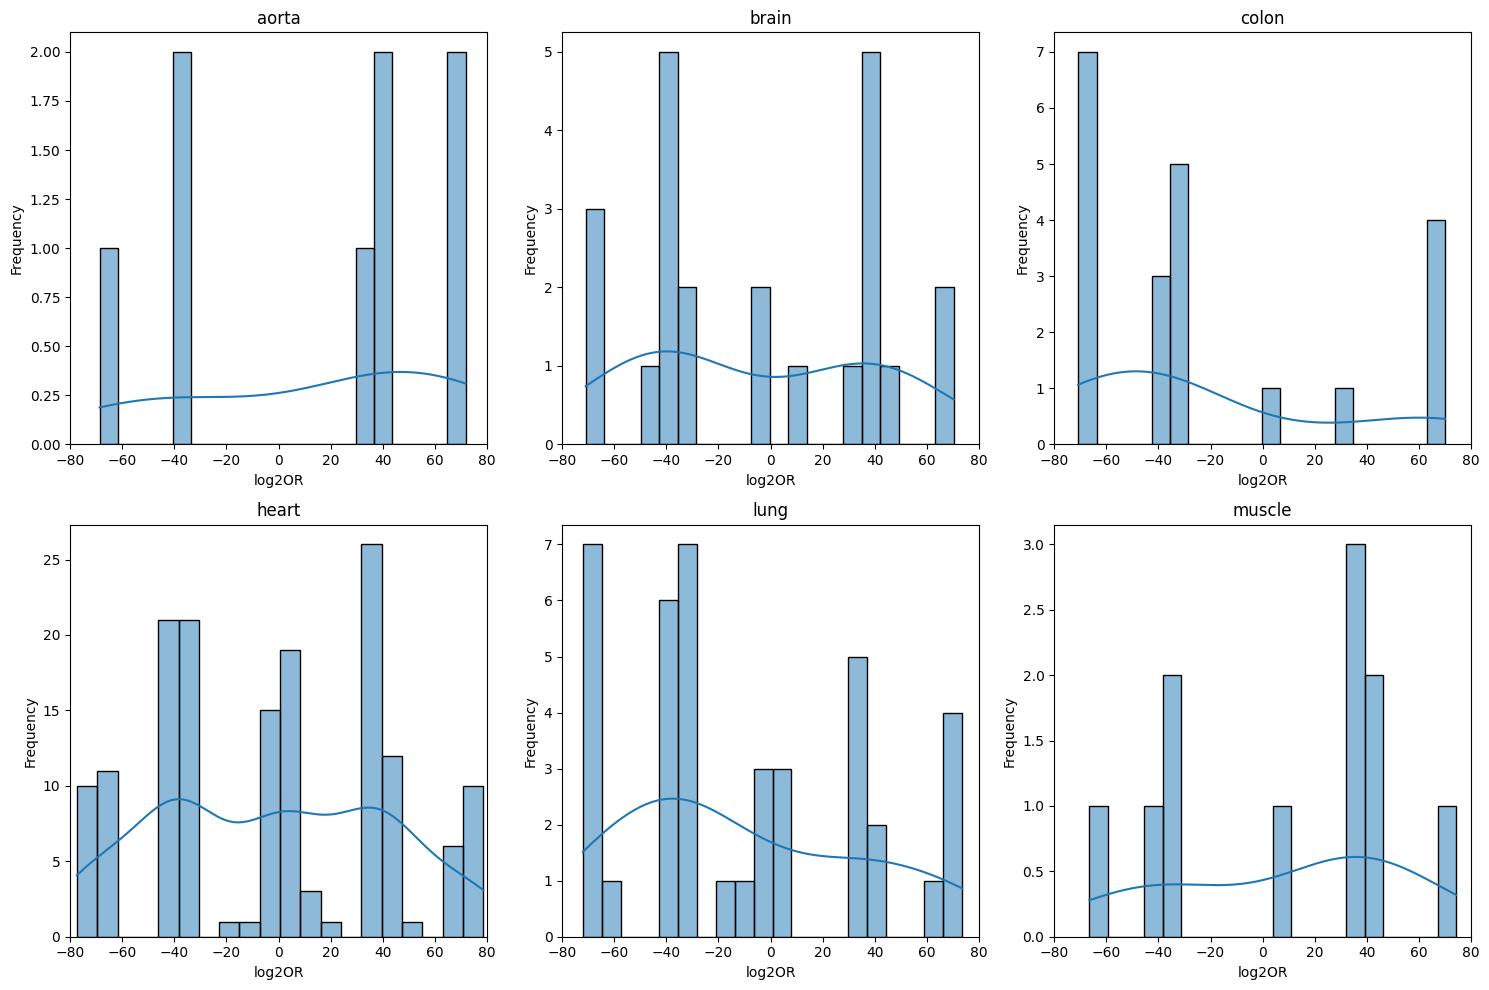

In [24]:
# 2x3 subplot grid of histograms
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    sns.histplot(coordination_results_sig[i]["log2OR"], bins=20, kde=True, ax=ax)
    # Limit x to -80 to 80
    ax.set_xlim(-80, 80)
    # Limit y to 0 to 80
    # ax.set_ylim(0, 25)
    ax.set_xlabel("log2OR")
    ax.set_ylabel("Frequency")
    ax.set_title(TISSUES[i])

fig.tight_layout()

In [25]:
# Taken from Carmine with minor adjustments
# https://github.com/carmineceraolo/splicing-coordination/blob/main/sheet05.ipynb
def volcano_plot(df,ax = None,sig=0.05,sigor=1.5,tag="(add a tag)",normalized=False):
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,5))

    palette=sns.color_palette().as_hex()
    colors=[]

    for i,r in df.iterrows():
        if r.padj>=sig or abs(r.log2OR)<=sigor:
            colors.append(palette[7])
        else:
            colors.append(palette[0])

    x=np.array(df.log2OR)

    if normalized:
        sigor-=np.mean(x)
        sigor/=np.std(x)
        x-=np.mean(x)
        x/=np.std(x)

        y=np.array(df.padj)

        sig-=np.mean(y)
        sig/=np.std(y)

        y-=np.mean(y)
        y/=np.std(y)
        y=-np.log10(y)
        title=f"Normalized volcano plot of {tag}"
    else:
        y=np.array(-np.log10(np.where(df.padj == 0, sys.float_info.min, df.padj)))
        title=tag
        # title=f"Volcano plot of {tag}"

    ax.scatter(x,y,c=colors)
    ax.axhline(y=-np.log10(sig),color="red",linestyle='dotted',label=f"padj = {sig}")
    ax.axvline(x=sigor,color="green",linestyle='dotted',label=f"log2OR threshold = {sigor}")
    ax.axvline(x=-sigor,color="green",linestyle='dotted')

    ax.set_xlim(-80,80)
    # ax.set_ylim(0, 320)

    ax.set_title(title,fontsize=13)
    ax.set_ylabel("-log10(p_value)",fontsize=12)
    ax.set_xlabel("log2OR",fontsize=12)
    # ax.legend(frameon=True,fontsize=12)

In [26]:
coordination_results[1].loc[coordination_results[1].padj == 0]

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,dcPSI_AB,dcPSI_BA,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids


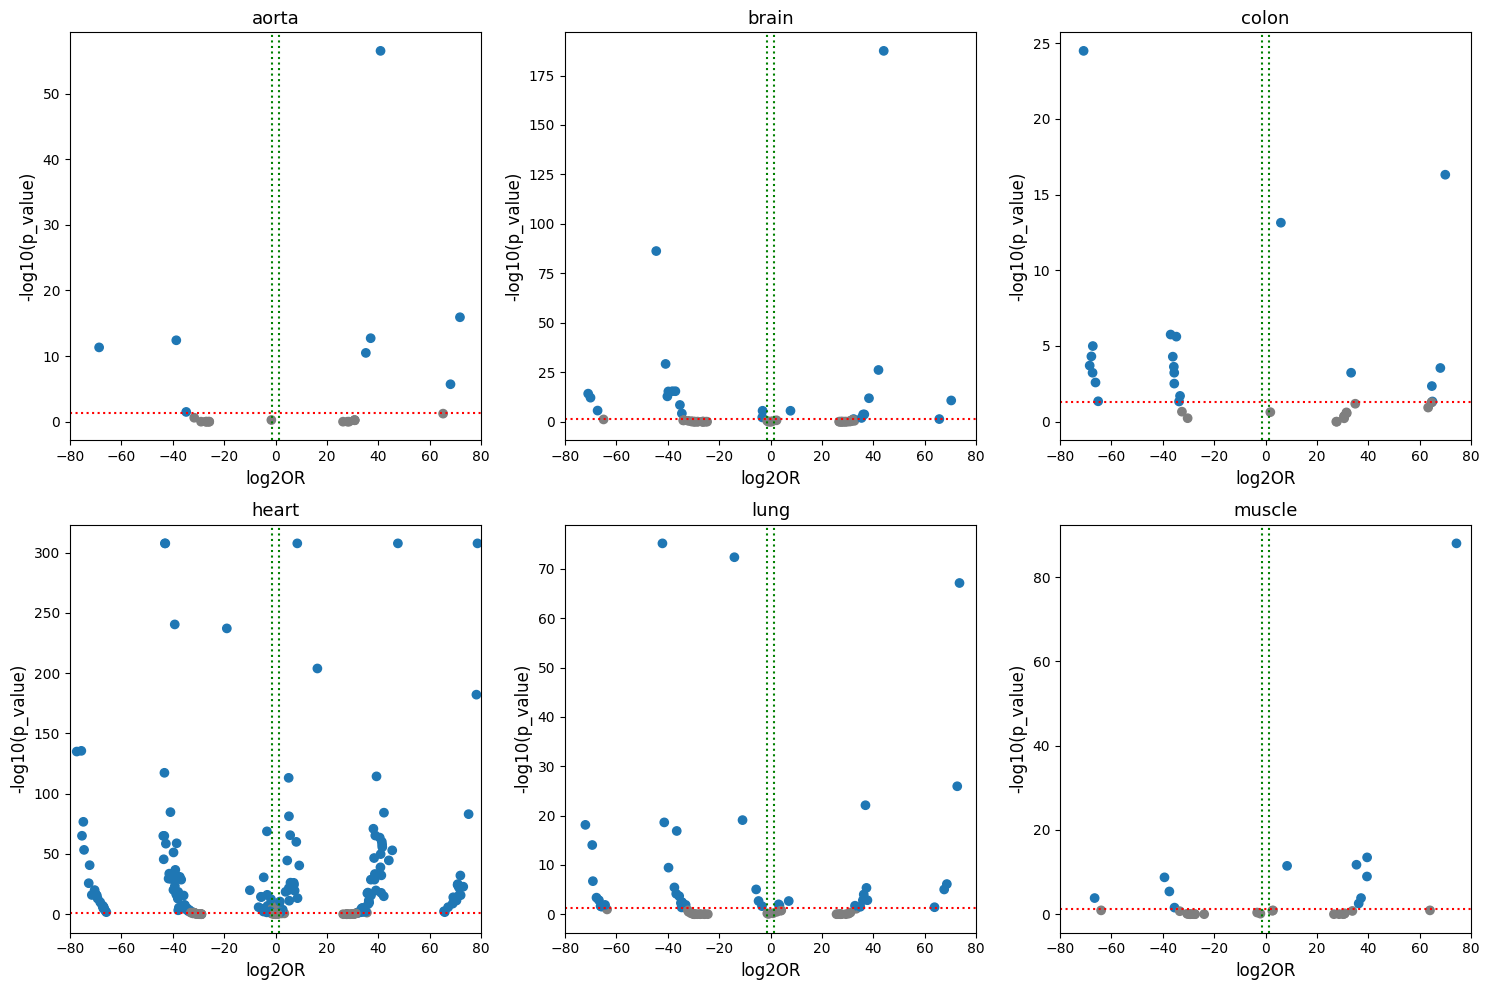

In [27]:
# 2x3 subplot grid of volcano plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flat):
    volcano_plot(coordination_results[i], ax=ax, tag=TISSUES[i])
fig.tight_layout()

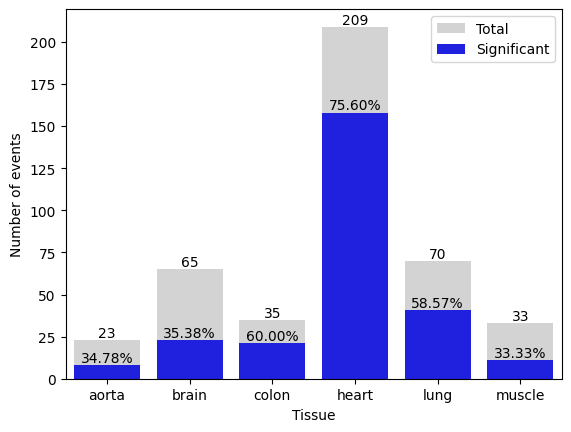

In [28]:
# Percentage of significant coordination
tmp = [[TISSUES[i], len(c[c["padj"] < 0.05]) / len(c), len(c[c["padj"] < 0.05]), len(c)] for i, c in enumerate(coordination_results)]
sig_coordination = pd.DataFrame(tmp, columns=["Tissue", "Percentage", "Significant", "Total"])

fig, ax = plt.subplots()
# stacked bar plot
ax1 = sns.barplot(data=sig_coordination, x="Tissue", y="Total", ax=ax, color="lightgrey", label="Total")
ax1.bar_label(ax1.containers[0], label_type='edge', fontsize=10)
ax2 = sns.barplot(data=sig_coordination, x="Tissue", y="Significant", ax=ax, color="blue", label="Significant")
ax2.bar_label(ax2.containers[1], label_type='edge', fontsize=10, labels=["{:.2f}%".format(i*100) for i in sig_coordination["Percentage"]])
# Bar labels
# for p in ax.patches:
#     ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

ax.set_ylabel("Number of events")
# plt.title("Coordination events")
plt.legend()

In [29]:
# List of gene_ids for each tissue with significant and total coordination, number of events split by positive and negative log2OR
# multi index with gene_id, total/significant, positive/negative
# series with counts

for i, c in enumerate(coordination_results):
    print(TISSUES[i])
    df = c[c["padj"] < 0.05]
    df["sign"] = np.where(df["log2OR"] > 0, "positive", "negative")
    print(df.groupby(["gene_id", "gene_name", "sign"]).size().sort_values(ascending=False))

aorta
gene_id             gene_name  sign    
ENSG00000049860.14  HEXB       positive    1
ENSG00000100664.11  EIF5       positive    1
ENSG00000132716.19  DCAF8      negative    1
                               positive    1
ENSG00000143387.14  CTSK       negative    1
ENSG00000173848.19  NET1       positive    1
ENSG00000179820.16  MYADM      negative    1
ENSG00000182944.18  EWSR1      positive    1
dtype: int64
brain
gene_id             gene_name   sign    
ENSG00000142875.21  PRKACB      positive    2
ENSG00000168824.15  NSG1        negative    2
ENSG00000140416.26  TPM1        negative    2
ENSG00000018189.13  RUFY3       positive    1
ENSG00000100591.8   AHSA1       positive    1
ENSG00000095787.26  WAC         positive    1
ENSG00000087258.17  GNAO1       negative    1
ENSG00000102471.16  NDFIP2      positive    1
ENSG00000124762.14  CDKN1A      negative    1
ENSG00000125652.8   ALKBH7      negative    1
ENSG00000120251.22  GRIA2       negative    1
ENSG00000117682.18  DHDDS   

/scratch/local/ipykernel_91383/2196527779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sign"] = np.where(df["log2OR"] > 0, "positive", "negative")
/scratch/local/ipykernel_91383/2196527779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sign"] = np.where(df["log2OR"] > 0, "positive", "negative")
/scratch/local/ipykernel_91383/2196527779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [30]:
# get all entries for ENSG00000168484.13 in lung
lung = coordination_results[4]
print(lung[lung["gene_id"] == "ENSG00000168484.13"])
# plot full contingency table of all TSS with all PAS
starts = list(set(lung.loc[lung["gene_id"] == "ENSG00000168484.13", ["eventA_start"]].values + lung.loc[lung["gene_id"] == "ENSG00000168484.13", ["eventA_end"]].values))
starts

Empty DataFrame
Columns: [gene_id, gene_name, strand, eventA_type, eventB_type, eventA_start, eventA_end, eventB_start, eventB_end, pvalue, padj, statistic, log2OR, dcPSI_AB, dcPSI_BA, priA_priB, priA_altB, altA_priB, altA_altB, priA_priB_transcript_ids, priA_altB_transcript_ids, altA_priB_transcript_ids, altA_altB_transcript_ids]
Index: []

[0 rows x 23 columns]


[]

In [31]:
grouped = []
for df in coordination_results:
    # Define significance threshold
    significance_threshold = 0.05

    # Define conditions
    all_events = df['log2OR'].notna()  # All rows
    significant_events = df['padj'] < significance_threshold
    positive_events = df['log2OR'] > 0
    negative_events = df['log2OR'] < 0
    neutral_events = df['log2OR'] == 0

    # Create new columns for the boolean conditions
    df['all_positive'] = all_events & positive_events
    df['all_negative'] = all_events & negative_events
    df['all_neutral'] = all_events & neutral_events
    df['significant_positive'] = significant_events & positive_events
    df['significant_negative'] = significant_events & negative_events
    df['significant_neutral'] = significant_events & neutral_events

    # Group by 'gene_id' and 'gene_name', and aggregate the counts
    counts_df = df.groupby(['gene_id', 'gene_name']).agg(
        all_positive=('all_positive', 'sum'),
        all_negative=('all_negative', 'sum'),
        all_neutral=('all_neutral', 'sum'),
        significant_positive=('significant_positive', 'sum'),
        significant_negative=('significant_negative', 'sum'),
        significant_neutral=('significant_neutral', 'sum')
    )
    # Create MultiIndex for columns
    counts_df.columns = pd.MultiIndex.from_tuples([
        ('all', 'positive'),
        ('all', 'negative'),
        ('all', 'neutral'),
        ('significant', 'positive'),
        ('significant', 'negative'),
        ('significant', 'neutral')
    ], names=['padj', 'log2OR'])

    # Output the result DataFrame with MultiIndex columns
    grouped.append(counts_df)
df = grouped[3]
df

padj                                all                  significant           \
log2OR                         positive negative neutral    positive negative   
gene_id            gene_name                                                    
ENSG00000037749.13 MFAP3              0        3       0           0        2   
ENSG00000051620.11 HEBP2              1        0       0           1        0   
ENSG00000058668.16 ATP2B4             1        0       0           1        0   
ENSG00000060642.12 PIGV               0        1       0           0        0   
ENSG00000063245.15 EPN1               0        1       0           0        1   
...                                 ...      ...     ...         ...      ...   
ENSG00000235535.9  TRDN-AS1           1        1       0           1        0   
ENSG00000241135.8  LINC00881          1        0       0           1        0   
ENSG00000248932.8  COPB2-DT           1        0       0           0        0   
ENSG00000259030.8  FPGT-TNNI3K        4        2       0           3        2   
ENSG00000293514.1  CUTALP             1        0       0           0        0   

padj                                    
log2OR                         neutral  
gene_id            gene_name            
ENSG00000037749.13 MFAP3             0  
ENSG00000051620.11 HEBP2             0  
ENSG00000058668.16 ATP2B4            0  
ENSG00000060642.12 PIGV              0  
ENSG00000063245.15 EPN1              0  
...                                ...  
ENSG00000235535.9  TRDN-AS1          0  
ENSG00000241135.8  LINC00881         0  
ENSG00000248932.8  COPB2-DT          0  
ENSG00000259030.8  FPGT-TNNI3K       0  
ENSG00000293514.1  CUTALP            0  

[96 rows x 6 columns]

In [32]:
# Concatenate all tissues horizontally and use tissue as a new level in the column MultiIndex
df_all = pd.concat(grouped, axis=1, keys=TISSUES, names=['tissue'])
df_all

tissue                          aorta                                        \
padj                              all                  significant            
log2OR                       positive negative neutral    positive negative   
gene_id            gene_name                                                  
ENSG00000011304.22 PTBP1          0.0      1.0     0.0         0.0      0.0   
ENSG00000049860.14 HEXB           1.0      0.0     0.0         1.0      0.0   
ENSG00000100664.11 EIF5           1.0      0.0     0.0         1.0      0.0   
ENSG00000102119.12 EMD            0.0      1.0     0.0         0.0      0.0   
ENSG00000104976.13 SNAPC2         1.0      0.0     0.0         0.0      0.0   
...                               ...      ...     ...         ...      ...   
ENSG00000161011.20 SQSTM1         NaN      NaN     NaN         NaN      NaN   
ENSG00000170035.16 UBE2E3         NaN      NaN     NaN         NaN      NaN   
ENSG00000171033.13 PKIA           NaN      NaN     NaN         NaN      NaN   
ENSG00000185262.9  UBALD2         NaN      NaN     NaN         NaN      NaN   
ENSG00000214756.8  CSKMT          NaN      NaN     NaN         NaN      NaN   

tissue                                  brain                               \
padj                                      all                  significant   
log2OR                       neutral positive negative neutral    positive   
gene_id            gene_name                                                 
ENSG00000011304.22 PTBP1         0.0      NaN      NaN     NaN         NaN   
ENSG00000049860.14 HEXB          0.0      NaN      NaN     NaN         NaN   
ENSG00000100664.11 EIF5          0.0      NaN      NaN     NaN         NaN   
ENSG00000102119.12 EMD           0.0      NaN      NaN     NaN         NaN   
ENSG00000104976.13 SNAPC2        0.0      NaN      NaN     NaN         NaN   
...                              ...      ...      ...     ...         ...   
ENSG00000161011.20 SQSTM1        NaN      NaN      NaN     NaN         NaN   
ENSG00000170035.16 UBE2E3        NaN      NaN      NaN     NaN         NaN   
ENSG00000171033.13 PKIA          NaN      NaN      NaN     NaN         NaN   
ENSG00000185262.9  UBALD2        NaN      NaN      NaN     NaN         NaN   
ENSG00000214756.8  CSKMT         NaN      NaN      NaN     NaN         NaN   

tissue                        ...    lung                               \
padj                          ...     all significant                    
log2OR                        ... neutral    positive negative neutral   
gene_id            gene_name  ...                                        
ENSG00000011304.22 PTBP1      ...     0.0         2.0      0.0     0.0   
ENSG00000049860.14 HEXB       ...     NaN         NaN      NaN     NaN   
ENSG00000100664.11 EIF5       ...     NaN         NaN      NaN     NaN   
ENSG00000102119.12 EMD        ...     NaN         NaN      NaN     NaN   
ENSG00000104976.13 SNAPC2     ...     NaN         NaN      NaN     NaN   
...                           ...     ...         ...      ...     ...   
ENSG00000161011.20 SQSTM1     ...     NaN         NaN      NaN     NaN   
ENSG00000170035.16 UBE2E3     ...     NaN         NaN      NaN     NaN   
ENSG00000171033.13 PKIA       ...     NaN         NaN      NaN     NaN   
ENSG00000185262.9  UBALD2     ...     NaN         NaN      NaN     NaN   
ENSG00000214756.8  CSKMT      ...     NaN         NaN      NaN     NaN   

tissue                         muscle                                        \
padj                              all                  significant            
log2OR                       positive negative neutral    positive negative   
gene_id            gene_name                                                  
ENSG00000011304.22 PTBP1          NaN      NaN     NaN         NaN      NaN   
ENSG00000049860.14 HEXB           NaN      NaN     NaN         NaN      NaN   
ENSG00000100664.11 EIF5           NaN      NaN     NaN    

In [33]:
# Neutral in any tissue
df_all[(df_all[('aorta', 'all', 'neutral')] > 0) | (df_all[('brain', 'all', 'neutral')] > 0) | (df_all[('colon', 'all', 'neutral')] > 0) | (df_all[('heart', 'all', 'neutral')] > 0) | (df_all[('lung', 'all', 'neutral')] > 0) | (df_all[('muscle', 'all', 'neutral')] > 0)]

Empty DataFrame
Columns: [(aorta, all, positive), (aorta, all, negative), (aorta, all, neutral), (aorta, significant, positive), (aorta, significant, negative), (aorta, significant, neutral), (brain, all, positive), (brain, all, negative), (brain, all, neutral), (brain, significant, positive), (brain, significant, negative), (brain, significant, neutral), (colon, all, positive), (colon, all, negative), (colon, all, neutral), (colon, significant, positive), (colon, significant, negative), (colon, significant, neutral), (heart, all, positive), (heart, all, negative), (heart, all, neutral), (heart, significant, positive), (heart, significant, negative), (heart, significant, neutral), (lung, all, positive), (lung, all, negative), (lung, all, neutral), (lung, significant, positive), (lung, significant, negative), (lung, significant, neutral), (muscle, all, positive), (muscle, all, negative), (muscle, all, neutral), (muscle, significant, positive), (muscle, significant, negative), (muscle, significant, neutral)]
Index: []

[0 rows x 36 columns]

In [34]:
# Add totals
df_all[('all', 'all', 'positive')] = df_all.xs(('all', 'positive'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'all', 'negative')] = df_all.xs(('all', 'negative'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'all', 'neutral')] = df_all.xs(('all', 'neutral'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'all', 'total')] = df_all[('all', 'all', 'positive')] + df_all[('all', 'all', 'negative')] + df_all[('all', 'all', 'neutral')]
df_all[('all', 'significant', 'positive')] = df_all.xs(('significant', 'positive'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'significant', 'negative')] = df_all.xs(('significant', 'negative'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'significant', 'neutral')] = df_all.xs(('significant', 'neutral'), level=[1, 2], axis=1).sum(axis=1)
df_all[('all', 'significant', 'total')] = df_all[('all', 'significant', 'positive')] + df_all[('all', 'significant', 'negative')] + df_all[('all', 'significant', 'neutral')]
df_all

tissue                          aorta                                        \
padj                              all                  significant            
log2OR                       positive negative neutral    positive negative   
gene_id            gene_name                                                  
ENSG00000011304.22 PTBP1          0.0      1.0     0.0         0.0      0.0   
ENSG00000049860.14 HEXB           1.0      0.0     0.0         1.0      0.0   
ENSG00000100664.11 EIF5           1.0      0.0     0.0         1.0      0.0   
ENSG00000102119.12 EMD            0.0      1.0     0.0         0.0      0.0   
ENSG00000104976.13 SNAPC2         1.0      0.0     0.0         0.0      0.0   
...                               ...      ...     ...         ...      ...   
ENSG00000161011.20 SQSTM1         NaN      NaN     NaN         NaN      NaN   
ENSG00000170035.16 UBE2E3         NaN      NaN     NaN         NaN      NaN   
ENSG00000171033.13 PKIA           NaN      NaN     NaN         NaN      NaN   
ENSG00000185262.9  UBALD2         NaN      NaN     NaN         NaN      NaN   
ENSG00000214756.8  CSKMT          NaN      NaN     NaN         NaN      NaN   

tissue                                  brain                               \
padj                                      all                  significant   
log2OR                       neutral positive negative neutral    positive   
gene_id            gene_name                                                 
ENSG00000011304.22 PTBP1         0.0      NaN      NaN     NaN         NaN   
ENSG00000049860.14 HEXB          0.0      NaN      NaN     NaN         NaN   
ENSG00000100664.11 EIF5          0.0      NaN      NaN     NaN         NaN   
ENSG00000102119.12 EMD           0.0      NaN      NaN     NaN         NaN   
ENSG00000104976.13 SNAPC2        0.0      NaN      NaN     NaN         NaN   
...                              ...      ...      ...     ...         ...   
ENSG00000161011.20 SQSTM1        NaN      NaN      NaN     NaN         NaN   
ENSG00000170035.16 UBE2E3        NaN      NaN      NaN     NaN         NaN   
ENSG00000171033.13 PKIA          NaN      NaN      NaN     NaN         NaN   
ENSG00000185262.9  UBALD2        NaN      NaN      NaN     NaN         NaN   
ENSG00000214756.8  CSKMT         NaN      NaN      NaN     NaN         NaN   

tissue                        ...      muscle              all           \
padj                          ... significant              all            
log2OR                        ...    negative neutral positive negative   
gene_id            gene_name  ...                                         
ENSG00000011304.22 PTBP1      ...         NaN     NaN      2.0      2.0   
ENSG00000049860.14 HEXB       ...         NaN     NaN      1.0      0.0   
ENSG00000100664.11 EIF5       ...         NaN     NaN      1.0      0.0   
ENSG00000102119.12 EMD        ...         NaN     NaN      0.0      1.0   
ENSG00000104976.13 SNAPC2     ...         NaN     NaN      2.0      0.0   
...                           ...         ...     ...      ...      ...   
ENSG00000161011.20 SQSTM1     ...         0.0     0.0      0.0      1.0   
ENSG00000170035.16 UBE2E3     ...         0.0     0.0      1.0      0.0   
ENSG00000171033.13 PKIA       ...         0.0     0.0      0.0      1.0   
ENSG00000185262.9  UBALD2     ...         0.0     0.0      1.0      0.0   
ENSG00000214756.8  CSKMT      ...         1.0     0.0      0.0      1.0   

tissue                                                                         
padj                                       significant                         
log2OR                       neutral total    positive negative neutral total  
gene_id            gene_name                                                   
ENSG00000011304.22 PTBP1         0.0   4.0         2.0      0.0     0.0   2.0  
ENSG00000049860.14 HEXB          0.0   1.0         1.0      0.0     0.0   1.0  
ENSG00000100664.11 EIF5          0.0 

In [35]:
df_all.sort_values(by=('all', 'significant', 'total'), ascending=False).to_csv('results/coordination_counts.tsv', sep='\t')

In [36]:
# All events of CFLAR in coordination_results
cflar = pd.concat([c[c["gene_id"] == "ENSG00000003402.21"] for c in coordination_results], axis=0)
cflar

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids,all_positive,all_negative,all_neutral,significant_positive,significant_negative,significant_neutral


In [37]:
# All events of PRKAR1A in coordination_results
prkar1a = pd.concat([c[c["gene_id"] == "ENSG00000108946.17"] for c in coordination_results], axis=0)
prkar1a

,gene_id,gene_name,strand,eventA_type,eventB_type,eventA_start,eventA_end,eventB_start,eventB_end,pvalue,...,priA_priB_transcript_ids,priA_altB_transcript_ids,altA_priB_transcript_ids,altA_altB_transcript_ids,all_positive,all_negative,all_neutral,significant_positive,significant_negative,significant_neutral
52,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68514816,68530663,3.287121e-08,...,[],[3],[26],[],False,True,False,False,True,False
53,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68514816,68530905,2.180024e-16,...,[],[3],[1],"[18, 24]",False,True,False,False,True,False
54,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68514816,68551315,1.207038e-08,...,[],[3],[4],[17],False,True,False,False,True,False
55,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68516744,68530663,1.922966e-07,...,[],[23],[26],[],False,True,False,False,True,False
56,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68516744,68530905,5.595547e-14,...,[],[23],[1],"[18, 24]",False,True,False,False,True,False
57,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68516744,68551315,2.264081e-07,...,[],[23],[4],[17],False,True,False,False,True,False
58,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68530663,68530905,1.000000e+00,...,[26],[],[1],"[18, 24]",True,False,False,False,False,False
59,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68530663,68551315,6.310621e-02,...,[26],[],[4],[17],True,False,False,False,False,False
60,ENSG00000108946.17,PRKAR1A,+,TSS,PAS,68511984,68512449,68530905,68551315,1.068755e-04,...,[1],"[18, 24]",[4],[17],True,False,False,True,False,False


In [38]:
# get splice_graph of ENSG00000117682.18 in brain
brain = isoseqs[1]
sg = brain['ENSG00000117682.18'].segment_graph_filtered(query='SQANTI_SUPPORT')
sg._graph

[(26432378, 26432379, {}, {0: 1}),
 (26432379, 26432518, {0: 0}, {0: 3, 1: 2}),
 (26432518, 26432890, {1: 1}, {1: 3}),
 (26432890, 26433008, {0: 1, 1: 2}, {0: 4, 1: 4}),
 (26438167, 26438284, {0: 3, 1: 3}, {0: 6, 1: 5}),
 (26441598, np.int64(26442230), {1: 4}, {}),
 (26442730, 26442873, {0: 4}, {0: 7}),
 (26446315, 26446432, {0: 6}, {0: 8}),
 (26447558, 26447660, {0: 7}, {0: 9}),
 (26457790, 26457905, {0: 8}, {0: 10}),
 (26460036, 26460144, {0: 9}, {0: 11}),
 (26468894, np.int64(26471294), {0: 10}, {})]